In [46]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Installing mglearn
!pip install mglearn

Processed Match Dataset:
                    team1                        team2  \
0     Sunrisers Hyderabad  Royal Challengers Bangalore   
1          Mumbai Indians       Rising Pune Supergiant   
2           Gujarat Lions        Kolkata Knight Riders   
3  Rising Pune Supergiant              Kings XI Punjab   
5           Gujarat Lions          Sunrisers Hyderabad   

                   toss_winner toss_decision  winner  win_by_runs  \
0  Royal Challengers Bangalore         field       1           35   
1       Rising Pune Supergiant         field       0            0   
2        Kolkata Knight Riders         field       0            0   
3              Kings XI Punjab         field       0            0   
5          Sunrisers Hyderabad         field       0            0   

   win_by_wickets         umpire1        umpire2  target_runs  \
0               0     AY Dandekar       NJ Llong          207   
1               7  A Nand Kishore         S Ravi          184   
2              1

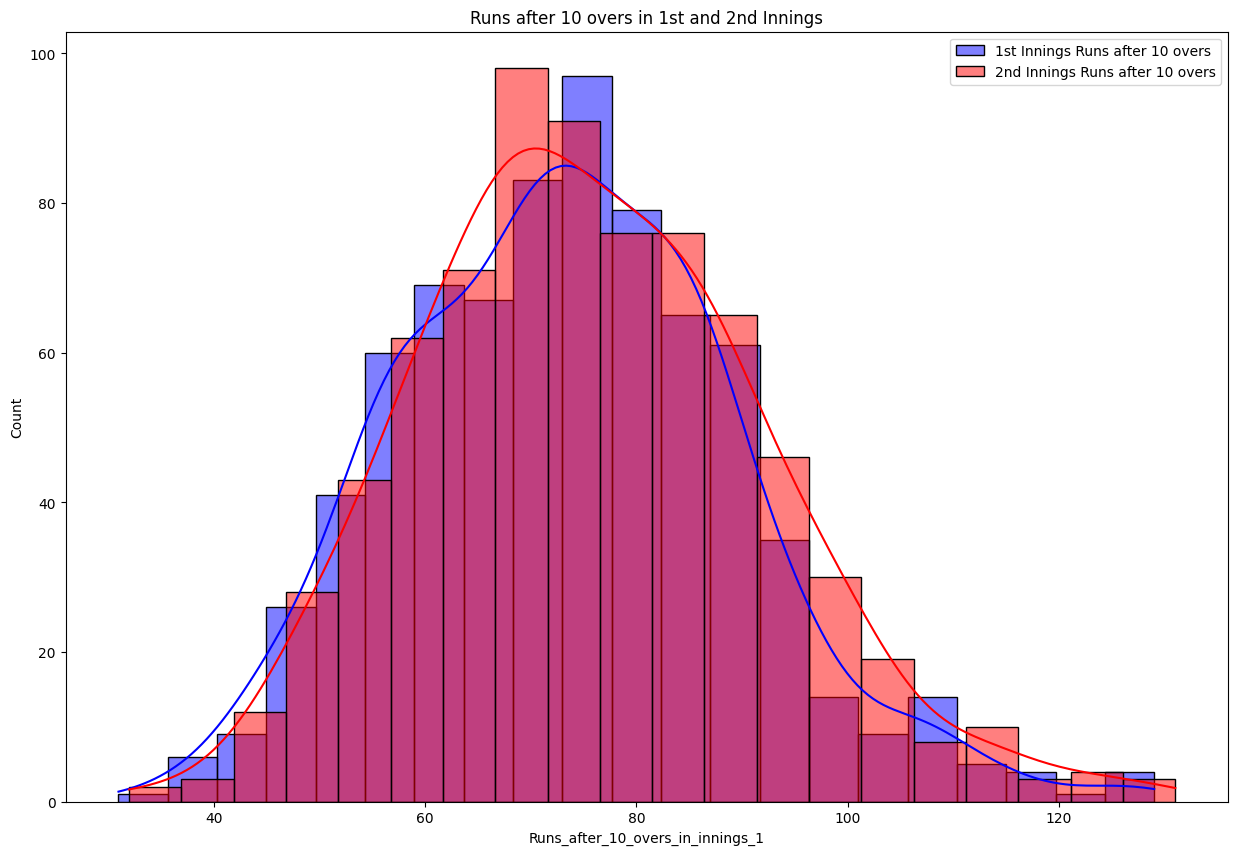

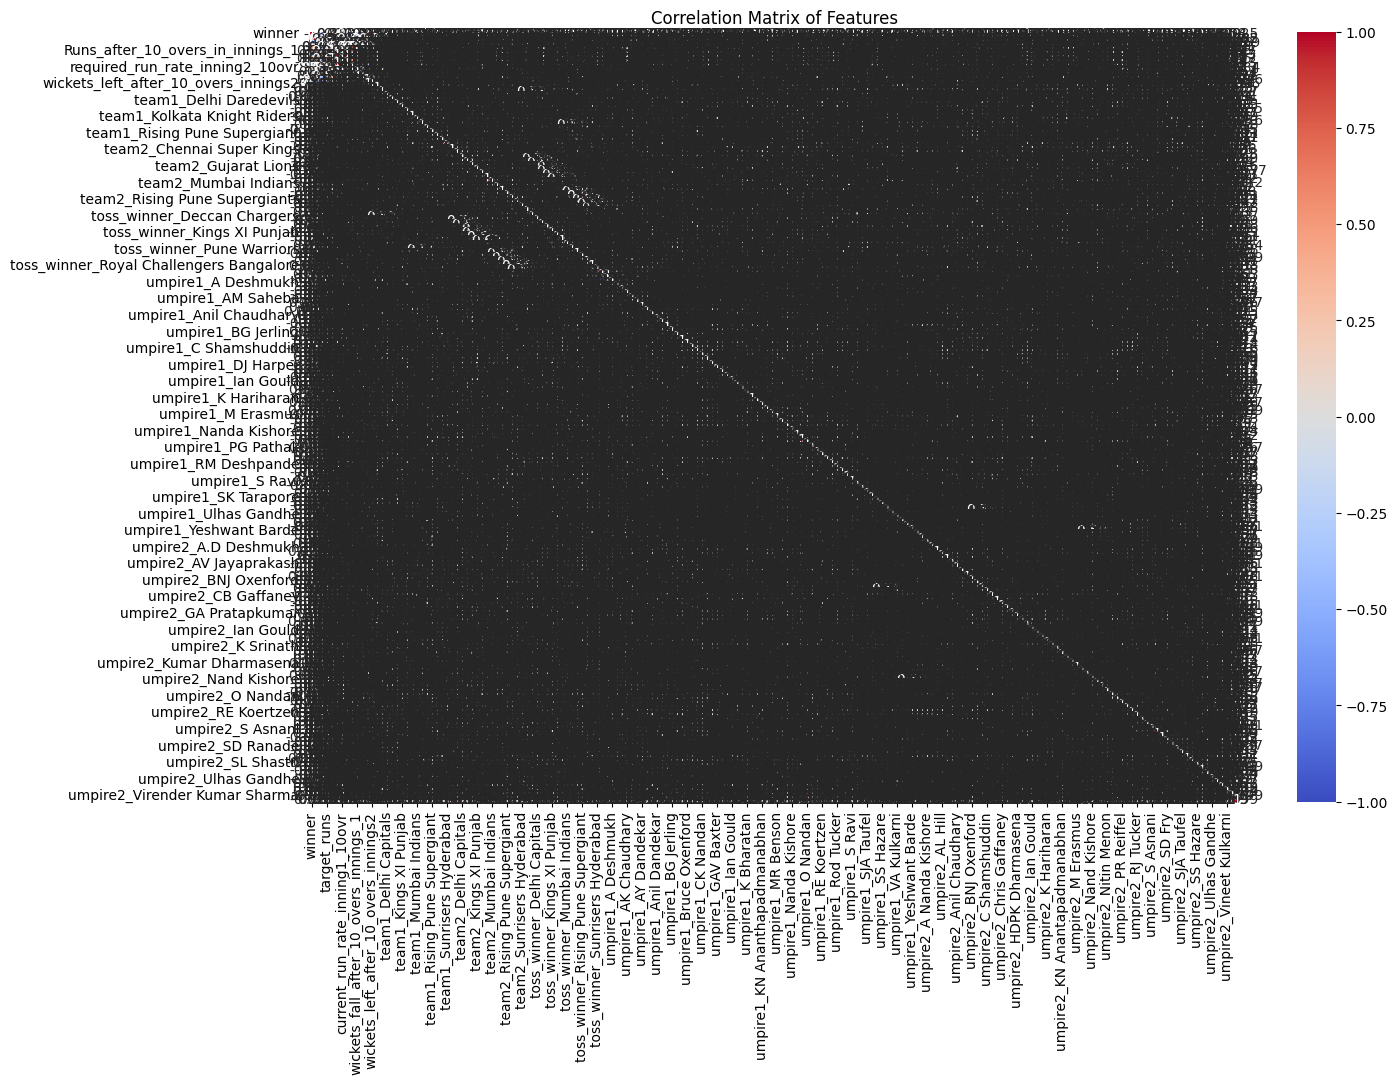

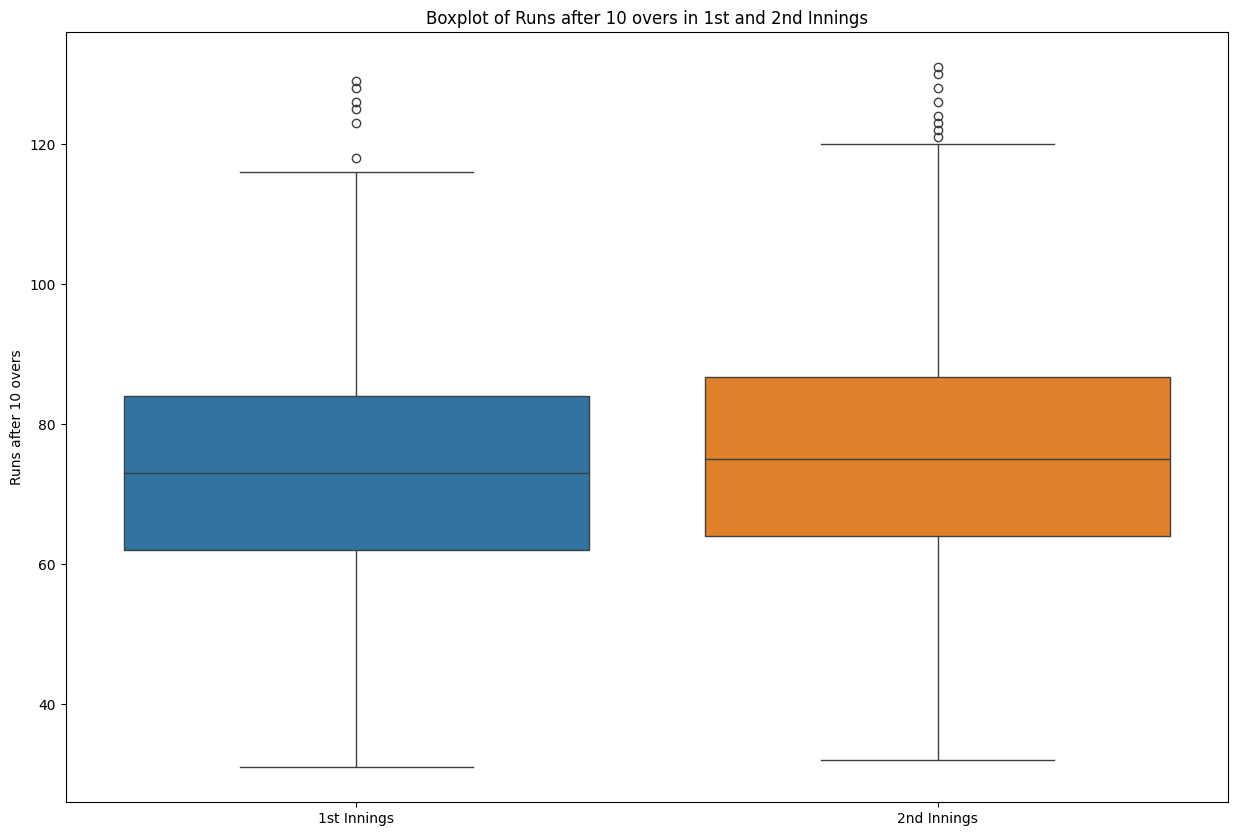

In [48]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize

# Load datasets
# Adjust path accordingly
match_dataset = pd.read_csv('/content/drive/MyDrive/datasets/matches.csv')
delivery_dataset = pd.read_csv('/content/drive/MyDrive/datasets/deliveries (1).csv')

# Starting data preprocessing
# Adding relevant features to the match dataset from the delivery dataset
total_runs_per_innings = delivery_dataset.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
total_runs_per_first_innings = total_runs_per_innings[total_runs_per_innings['inning'] == 1]

# Merge total runs of the first innings with match dataset
match_dataset.rename(columns={'id': 'match_id'}, inplace=True)
match_dataset = match_dataset.merge(total_runs_per_first_innings, on='match_id', how='left')
match_dataset.drop('inning', axis=1, inplace=True)
match_dataset.rename(columns={'total_runs': 'target_runs'}, inplace=True)

# Total runs after 10 overs in the first innings
runs_10_overs_1st_innings = delivery_dataset[(delivery_dataset['inning'] == 1) & (delivery_dataset['over'] <= 10)]
runs_10_overs_1st_innings = runs_10_overs_1st_innings.groupby(['match_id'])['total_runs'].sum().reset_index()
runs_10_overs_1st_innings.rename(columns={'total_runs': 'Runs_after_10_overs_in_innings_1'}, inplace=True)
match_dataset = match_dataset.merge(runs_10_overs_1st_innings, on='match_id', how='left')

# Total runs after 10 overs in the second innings
runs_10_overs_2nd_innings = delivery_dataset[(delivery_dataset['inning'] == 2) & (delivery_dataset['over'] <= 10)]
runs_10_overs_2nd_innings = runs_10_overs_2nd_innings.groupby(['match_id'])['total_runs'].sum().reset_index()
runs_10_overs_2nd_innings.rename(columns={'total_runs': 'Runs_after_10_overs_in_innings_2'}, inplace=True)
match_dataset = match_dataset.merge(runs_10_overs_2nd_innings, on='match_id', how='left')

# Calculate current run rates after 10 overs
match_dataset['current_run_rate_inning1_10ovr'] = match_dataset['Runs_after_10_overs_in_innings_1'] / 10
match_dataset['current_run_rate_inning2_10ovr'] = match_dataset['Runs_after_10_overs_in_innings_2'] / 10

# Calculate required run rate after 10 overs in the second innings
match_dataset['required_run_rate_inning2_10ovr'] = (match_dataset['target_runs'] - match_dataset['Runs_after_10_overs_in_innings_2']) / 10

# Adding wickets fallen after 10 overs in both innings
delivery_dataset['player_dismissed'].fillna(0, inplace=True)
delivery_dataset['player_dismissed'] = delivery_dataset['player_dismissed'].apply(lambda x: 0 if x == 0 else 1)

wickets_10_overs_1st_innings = delivery_dataset[(delivery_dataset['inning'] == 1) & (delivery_dataset['over'] <= 10)]
wickets_10_overs_1st_innings = wickets_10_overs_1st_innings.groupby(['match_id'])['player_dismissed'].sum().reset_index()
wickets_10_overs_1st_innings.rename(columns={'player_dismissed': 'wickets_fall_after_10_overs_innings_1'}, inplace=True)
match_dataset = match_dataset.merge(wickets_10_overs_1st_innings, on='match_id', how='left')
match_dataset['wickets_left_after_10_overs_innings1'] = 10 - match_dataset['wickets_fall_after_10_overs_innings_1']

wickets_10_overs_2nd_innings = delivery_dataset[(delivery_dataset['inning'] == 2) & (delivery_dataset['over'] <= 10)]
wickets_10_overs_2nd_innings = wickets_10_overs_2nd_innings.groupby(['match_id'])['player_dismissed'].sum().reset_index()
wickets_10_overs_2nd_innings.rename(columns={'player_dismissed': 'wickets_fall_after_10_overs_innings_2'}, inplace=True)
match_dataset = match_dataset.merge(wickets_10_overs_2nd_innings, on='match_id', how='left')
match_dataset['wickets_left_after_10_overs_innings2'] = 10 - match_dataset['wickets_fall_after_10_overs_innings_2']

# Drop unnecessary columns
columns_to_drop = ['match_id', 'Season', 'date', 'city', 'venue', 'player_of_match', 'result', 'dl_applied']
match_dataset.drop(columns_to_drop, axis=1, inplace=True)

# Drop umpire3 due to many missing values
match_dataset.drop('umpire3', axis=1, inplace=True)

# Remove rows with missing values
match_dataset.dropna(inplace=True)

# Convert the winner to a boolean where 1 represents team1 won and 0 represents team2 won
match_dataset['winner'] = match_dataset['winner'] == match_dataset['team1']
match_dataset['winner'] = match_dataset['winner'].astype(int)

print("Processed Match Dataset:")
print(match_dataset.head())

# Converting categorical columns to numerical using one-hot encoding
match_dataset_encoded = pd.get_dummies(match_dataset, columns=['team1', 'team2', 'toss_winner', 'toss_decision', 'umpire1', 'umpire2'])

# Exploratory Data Analysis (EDA)
# Visualize distributions of numeric features
plt.figure(figsize=(15, 10))
sns.histplot(match_dataset_encoded['Runs_after_10_overs_in_innings_1'], kde=True, color='blue', label='1st Innings Runs after 10 overs')
sns.histplot(match_dataset_encoded['Runs_after_10_overs_in_innings_2'], kde=True, color='red', label='2nd Innings Runs after 10 overs')
plt.title('Runs after 10 overs in 1st and 2nd Innings')
plt.legend()
plt.show()

# Visualize correlation matrix
plt.figure(figsize=(15, 10))
correlation_matrix = match_dataset_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

# Boxplot of runs after 10 overs by inning
plt.figure(figsize=(15, 10))
sns.boxplot(data=[match_dataset_encoded['Runs_after_10_overs_in_innings_1'], match_dataset_encoded['Runs_after_10_overs_in_innings_2']])
plt.xticks([0, 1], ['1st Innings', '2nd Innings'])
plt.ylabel('Runs after 10 overs')
plt.title('Boxplot of Runs after 10 overs in 1st and 2nd Innings')
plt.show()

# Classifying the features and the targets
target = match_dataset_encoded['winner'].values
features = match_dataset_encoded.drop('winner', axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)







The accuracy is 98.66666666666667%
[[92  2]
 [ 0 56]]
              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99        94
     class 1       0.97      1.00      0.98        56

    accuracy                           0.99       150
   macro avg       0.98      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



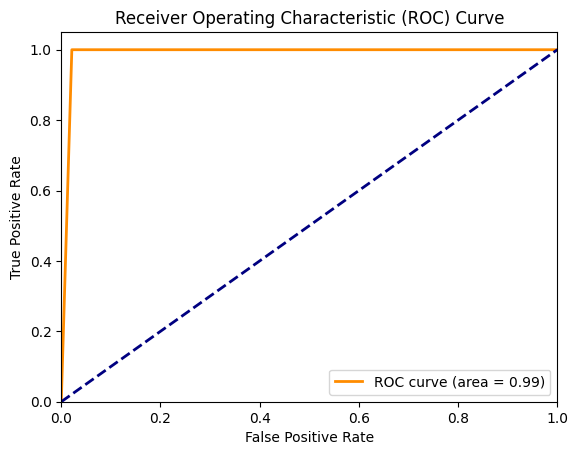

In [49]:
# Applying Logistic regression
logistic_regression = LogisticRegression(solver="liblinear", random_state=0)
model = logistic_regression.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("The accuracy is " + str(metrics.accuracy_score(Y_test, Y_pred) * 100) + "%")
print(confusion_matrix(Y_test, Y_pred))
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred, target_names=target_names))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The accuracy is 98.66666666666667%
[[92  2]
 [ 0 56]]
              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99        94
     class 1       0.97      1.00      0.98        56

    accuracy                           0.99       150
   macro avg       0.98      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



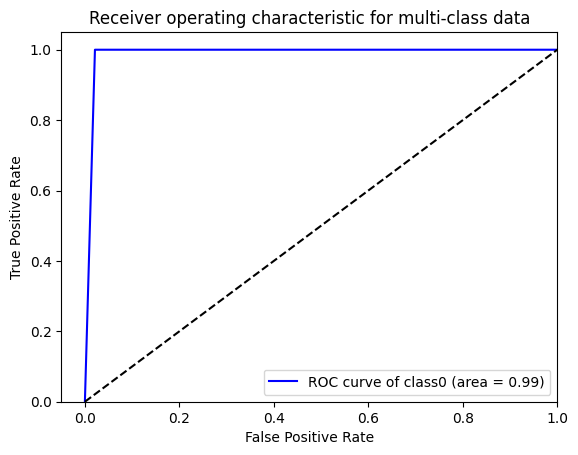

In [50]:
# Applying Decison tree alogrithm
from itertools import cycle

decisiontree = DecisionTreeClassifier(random_state=0)
model = decisiontree.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("The accuracy is " + str(metrics.accuracy_score(Y_test, Y_pred) * 100) + "%")
print(confusion_matrix(Y_test, Y_pred))
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred, target_names=target_names))
yt = label_binarize(target, classes=[0, 1])
n_classes = yt.shape[1]



fpr = dict()
tpr = dict()
roc_auc = dict()
Y_testt=label_binarize(Y_test, classes=[0, 1])
Y_predd=label_binarize(Y_pred, classes=[0, 1])
for i in range(n_classes):
 fpr[i], tpr[i], _ = roc_curve(Y_testt[:, i], Y_predd[:, i])
 roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red','green'])
for i, color in zip(range(n_classes), colors):
 plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class{0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


In [51]:

#Applying the Gradeint Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, Y_train)

# Predict and evaluate Gradient Boosting
gb_predictions = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(Y_test, gb_predictions)

print(f"Gradient Boosting Accuracy: {gb_accuracy}")



Gradient Boosting Accuracy: 0.9866666666666667


The accuracy is94.66666666666667%
[[92  2]
 [ 6 50]]
              precision    recall  f1-score   support

     class 0       0.94      0.98      0.96        94
     class 1       0.96      0.89      0.93        56

    accuracy                           0.95       150
   macro avg       0.95      0.94      0.94       150
weighted avg       0.95      0.95      0.95       150



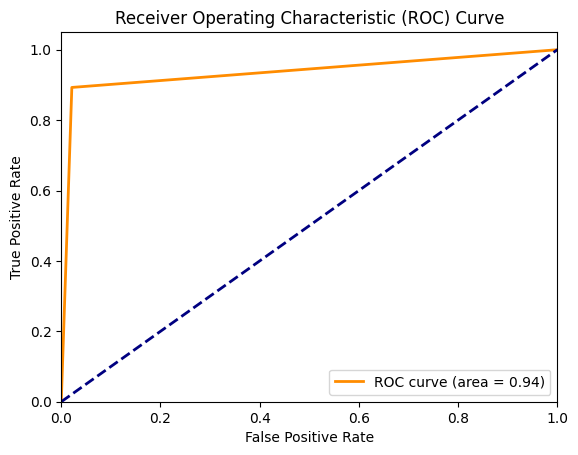

In [52]:
# Applying Naives Baysian Classifier
from sklearn.naive_bayes import GaussianNB
classifer = GaussianNB()
# Train model
model = classifer.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("The accuracy is" +str(metrics.accuracy_score(Y_test,Y_pred)*100)+"%")
print(confusion_matrix(Y_test, Y_pred))
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred, target_names=target_names))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [53]:
# #without python package
# # Load datasets manually using file reading
# import csv

# # Function to load CSV data
# def load_csv(filename):
#     dataset = []
#     with open(filename, 'r') as file:
#         csv_reader = csv.reader(file)
#         for row in csv_reader:
#             dataset.append(row)
#     return dataset

# # Load match and delivery datasets
# match_data = load_csv('/content/matches.csv')
# delivery_data = load_csv('/content/deliveries (1).csv')

# # Convert header rows to indices for easy referencing
# match_headers = match_data.pop(0)
# delivery_headers = delivery_data.pop(0)

# # Helper function to get column index by name
# def get_column_index(headers, column_name):
#     return headers.index(column_name)

# # Example of how to get specific columns (team1, team2, and winner)
# team1_index = get_column_index(match_headers, 'team1')
# team2_index = get_column_index(match_headers, 'team2')
# winner_index = get_column_index(match_headers, 'winner')

# # Print example of extracted columns
# print("Team 1:", match_data[0][team1_index])
# print("Team 2:", match_data[0][team2_index])
# print("Winner:", match_data[0][winner_index])


In [54]:
# # Handling missing values manually
# def handle_missing_values(data, replacement_value=0):
#     for row in data:
#         for i in range(len(row)):
#             if row[i] == '' or row[i] is None:
#                 row[i] = replacement_value
#     return data

# # Encode categorical variables manually
# def encode_categorical(data, column_index):
#     unique_values = list(set(row[column_index] for row in data))
#     encoding_map = {value: idx for idx, value in enumerate(unique_values)}
#     for row in data:
#         row[column_index] = encoding_map[row[column_index]]
#     return data, encoding_map

# # Handle missing values
# match_data = handle_missing_values(match_data)
# delivery_data = handle_missing_values(delivery_data)

# # Encode categorical variables
# match_data, team1_encoding = encode_categorical(match_data, team1_index)
# match_data, team2_encoding = encode_categorical(match_data, team2_index)
# match_data, winner_encoding = encode_categorical(match_data, winner_index)

# # Print encoded data example
# print("Encoded Team 1:", match_data[0][team1_index])
# print("Encoded Team 2:", match_data[0][team2_index])
# print("Encoded Winner:", match_data[0][winner_index])


In [55]:
# # Function to load CSV data
# def load_csv(filename):
#     dataset = []
#     with open(filename, 'r') as file:
#         csv_reader = csv.reader(file)
#         for row in csv_reader:
#             dataset.append(row)
#     return dataset

# # Load match dataset
# match_data = load_csv('/content/matches.csv')
# match_headers = match_data.pop(0)  # Extract and remove the header row

# # Print available column names to verify
# print("Available Columns in Match Dataset:", match_headers)

# # Load delivery dataset
# delivery_data = load_csv('/content/deliveries (1).csv')
# delivery_headers = delivery_data.pop(0)  # Extract and remove the header row

# # Print available column names to verify
# print("Available Columns in Delivery Dataset:", delivery_headers)


In [56]:
# import numpy as np
# import csv

# # Load datasets manually using file reading
# def load_csv(filename):
#     dataset = []
#     with open(filename, 'r') as file:
#         csv_reader = csv.reader(file)
#         for row in csv_reader:
#             dataset.append(row)
#     return dataset

# # Load match and delivery datasets
# match_data = load_csv('/content/matches.csv')
# delivery_data = load_csv('/content/deliveries (1).csv')

# # Extract headers
# match_headers = match_data.pop(0)
# delivery_headers = delivery_data.pop(0)

# # Function to get column index by name
# def get_column_index(headers, column_name):
#     return headers.index(column_name)

# # Preprocessing: Calculate total runs after 10 overs for both innings

# # Get necessary column indices
# match_id_index = get_column_index(delivery_headers, 'match_id')
# inning_index = get_column_index(delivery_headers, 'inning')
# over_index = get_column_index(delivery_headers, 'over')
# total_runs_index = get_column_index(delivery_headers, 'total_runs')

# # Initialize dictionaries to store the computed runs
# runs_after_10_overs_innings_1 = {}
# runs_after_10_overs_innings_2 = {}

# for row in delivery_data:
#     match_id = row[match_id_index]
#     inning = int(row[inning_index])
#     over = int(row[over_index])
#     total_runs = int(row[total_runs_index])

#     if inning == 1 and over <= 10:
#         if match_id not in runs_after_10_overs_innings_1:
#             runs_after_10_overs_innings_1[match_id] = 0
#         runs_after_10_overs_innings_1[match_id] += total_runs

#     if inning == 2 and over <= 10:
#         if match_id not in runs_after_10_overs_innings_2:
#             runs_after_10_overs_innings_2[match_id] = 0
#         runs_after_10_overs_innings_2[match_id] += total_runs

# # Adding computed runs to match dataset
# match_id_index = get_column_index(match_headers, 'id')
# new_match_data = []

# # Create a new header for the updated dataset
# new_match_headers = match_headers + ['Runs_after_10_overs_in_innings_1', 'Runs_after_10_overs_in_innings_2']

# for row in match_data:
#     match_id = row[match_id_index]
#     runs_1st = runs_after_10_overs_innings_1.get(match_id, 0)
#     runs_2nd = runs_after_10_overs_innings_2.get(match_id, 0)
#     new_row = row + [runs_1st, runs_2nd]
#     new_match_data.append(new_row)

# # Print the first few rows of the updated dataset
# print("First few rows of the updated match dataset with new features:")
# for row in new_match_data[:5]:
#     print(row)


TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [58]:
class GaussianNaiveBayesScratch:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0)
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def _calculate_likelihood(self, mean, var, x):
        eps = 1e-4
        coeff = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
        x = np.array(x, dtype=np.float64)
        exponent = np.exp(-((x - mean) ** 2) / (2 * var + eps))
        return coeff * exponent

    def _calculate_posterior(self, x):
        posteriors = []

        for c in self.classes:
            prior = np.log(self.priors[c])
            likelihood = np.sum(np.log(self._calculate_likelihood(self.mean[c], self.var[c], x)))
            posterior = prior + likelihood
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return np.array([self._calculate_posterior(x) for x in X])

# Before training the model, convert X_train and X_test to NumPy arrays with float dtype
X_train = np.array(X_train, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)

# Train and evaluate Gaussian Naive Bayes
gnb_model = GaussianNaiveBayesScratch()
gnb_model.fit(X_train, Y_train)
y_pred_gnb = gnb_model.predict(X_test)

# Calculate accuracy
accuracy_gnb = sum(y_pred_gnb == Y_test) / len(Y_test)
print(f"Gaussian Naive Bayes Accuracy: {accuracy_gnb * 100:.2f}%")


Gaussian Naive Bayes Accuracy: 93.33%


<ipython-input-58-fc54e7557ea7>:26: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self._calculate_likelihood(self.mean[c], self.var[c], x)))


In [59]:
import numpy as np

class GradientBoostingScratch:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    class DecisionTree:
        def __init__(self, max_depth=3):
            self.max_depth = max_depth

        def _split(self, X, y):
            m, n = X.shape
            if m <= 1:
                return None, None, None, None

            best_split = {'score': float('inf')}
            for feature_index in range(n):
                # Ensure classes are integers for indexing
                thresholds, classes = zip(*sorted(zip(X[:, feature_index], y.astype(int))))
                # Get unique classes and map them to consecutive integers
                unique_classes = np.unique(classes)
                class_mapping = {c: i for i, c in enumerate(unique_classes)}
                num_classes = len(unique_classes)
                num_left = [0] * num_classes
                num_right = np.bincount([class_mapping[c] for c in classes], minlength=num_classes).tolist()
                for i in range(1, m):
                    c = class_mapping[classes[i - 1]] # Map the class to its index
                    num_left[c] += 1
                    num_right[c] -= 1
                    gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(num_classes))
                    gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(num_classes))
                    gini = (i * gini_left + (m - i) * gini_right) / m
                    if thresholds[i] == thresholds[i - 1]:
                        continue
                    if gini < best_split['score']:
                        best_split = {
                            'score': gini,
                            'feature_index': feature_index,
                            'threshold': (thresholds[i] + thresholds[i - 1]) / 2,
                            'left': (X[:i, :], y[:i]),
                            'right': (X[i:, :], y[i:])
                        }
            return best_split['feature_index'], best_split['threshold'], best_split['left'], best_split['right']

        def _build_tree(self, X, y, depth=0):
            m, n = X.shape
            if m <= 1 or depth >= self.max_depth:
                return np.mean(y)

            feature_index, threshold, left, right = self._split(X, y)
            if not left or not right:
                return np.mean(y)

            left_tree = self._build_tree(left[0], left[1], depth + 1)
            right_tree = self._build_tree(right[0], right[1], depth + 1)
            return (feature_index, threshold, left_tree, right_tree)

        def fit(self, X, y):
            self.tree = self._build_tree(X, y)

        def _predict(self, x, tree):
            if not isinstance(tree, tuple):
                return tree
            feature_index, threshold, left_tree, right_tree = tree
            if x[feature_index] < threshold:
                return self._predict(x, left_tree)
            else:
                return self._predict(x, right_tree)

        def predict(self, X):
            return np.array([self._predict(x, self.tree) for x in X])

    def fit(self, X, y):
        self.trees = []
        self.F = np.zeros(y.shape)
        for _ in range(self.n_estimators):
            residuals = y - self.F
            tree = self.DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)
            self.F += self.learning_rate * tree.predict(X)

    def predict(self, X):
        F = np.zeros(X.shape[0])
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return np.round(F)

# Assuming X_train, y_train, X_test, and y_test are defined as in the previous example
# Train and evaluate Gradient Boosting
gb_model = GradientBoostingScratch(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, Y_train)
y_pred_gb = gb_model.predict(X_test)

# Calculate accuracy
accuracy_gb = sum(y_pred_gb == Y_test) / len(Y_test)
print(f"Gradient Boosting Accuracy: {accuracy_gb * 100:.2f}%")




Gradient Boosting Accuracy: 1.33%


In [60]:
import numpy as np

class DecisionTreeScratch:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None

    def _gini(self, y):
        """Calculate the Gini impurity for a list of classes."""
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    def _split(self, X, y, feature_index, threshold):
        """Split the dataset based on a feature and a threshold."""
        left_mask = X[:, feature_index] < threshold
        right_mask = ~left_mask
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _best_split(self, X, y):
        """Find the best split for a node."""
        m, n = X.shape
        if m <= 1:
            return None, None

        best_gini = float('inf')
        best_idx, best_thr = None, None
        for feature_index in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, feature_index], y)))
            for i in range(1, m):
                if thresholds[i] == thresholds[i - 1]:
                    continue
                gini = (i * self._gini(classes[:i]) + (m - i) * self._gini(classes[i:])) / m
                if gini < best_gini:
                    best_gini = gini
                    best_idx = feature_index
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        """Recursively build the tree."""
        m, n = X.shape
        if m == 0 or depth >= self.max_depth:
            return np.mean(y)

        feature_index, threshold = self._best_split(X, y)
        if feature_index is None:
            return np.mean(y)

        left_X, left_y, right_X, right_y = self._split(X, y, feature_index, threshold)
        left_tree = self._build_tree(left_X, left_y, depth + 1)
        right_tree = self._build_tree(right_X, right_y, depth + 1)
        return (feature_index, threshold, left_tree, right_tree)

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _predict(self, x, tree):
        """Predict a single sample."""
        if not isinstance(tree, tuple):
            return tree
        feature_index, threshold, left_tree, right_tree = tree
        if x[feature_index] < threshold:
            return self._predict(x, left_tree)
        else:
            return self._predict(x, right_tree)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

# Usage example with training and testing data (assuming X_train, y_train, X_test, y_test are already defined):
dt_model = DecisionTreeScratch(max_depth=3)
dt_model.fit(X_train, Y_train)
y_pred_dt = dt_model.predict(X_test)

# Calculate accuracy
accuracy_dt = np.sum(y_pred_dt == Y_test) / len(Y_test)
print(f"Decision Tree Accuracy: {accuracy_dt * 100:.2f}%")


Decision Tree Accuracy: 98.67%


In [61]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
    def sigmoid(self, z):
      # Handle the case where z is a scalar (0-dimensional array)
        if np.ndim(z) == 0:
            return 1 / (1 + np.exp(-float(z)))  # Convert scalar to float explicitly
        else:
            return 1 / (1 + np.exp(-z))  # Handle array-like objects as before

    def fit(self, X, y):
        # Ensure X and y are NumPy arrays
        X = np.array(X)
        y = np.array(y)

        self.m, self.n = X.shape
        self.theta = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.theta) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / self.m) * np.dot(X.T, (y_predicted - y))
            db = (1 / self.m) * np.sum(y_predicted - y)

            self.theta -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        # Ensure X is a NumPy array
        X = np.array(X)

        linear_model = np.dot(X, self.theta) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]


lr_model = LogisticRegressionScratch(learning_rate=0.01, iterations=1000)
# Ensure X_train is a NumPy array before fitting
lr_model.fit(np.array(X_train), Y_train)

# Predict using the model
y_pred_lr = lr_model.predict(X_test)

# Calculate accuracy
accuracy_lr = sum(y_pred_lr == Y_test) / len(Y_test)
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")


Logistic Regression Accuracy: 97.33%
